# Configuração de ambiente

In [1]:
!mkdir Image
!mkdir Image_Segmentation

In [ ]:
%pip install crewai crewai-tools poetry vllm
!curl -fsSL https://ollama.com/install.sh | sh
!pip install pymupdf langchain-community langchain-core langgraph faiss-cpu
!pip install langchain --upgrade

In [1]:
!nohup ollama serve > ollama.log &
!nohup ollama run llava:7b &

nohup: redirecting stderr to stdout
nohup: appending output to 'nohup.out'


# Criação da RAG leve com base no PDF

In [ ]:
import pymupdf  # PyMuPDF
import os
import zipfile

# Caminho do arquivo ZIP enviado pelo usuário
zip_path = "RAG.zip"
extracted_path = "extracted_pdfs"

# Extraindo os PDFs
os.makedirs(extracted_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Função para extrair texto de PDFs
def extract_text_from_pdfs(pdf_folder):
    text_data = ""
    for pdf_file in os.listdir(pdf_folder):
        if pdf_file.endswith(".pdf"):
            pdf_path = os.path.join(pdf_folder, pdf_file)
            doc = pymupdf.open(pdf_path)
            for page in doc:
                text_data += page.get_text("text") + "\n\n"
    return text_data

# Extraindo texto dos PDFs
medical_texts = extract_text_from_pdfs(extracted_path)

# Salvando em um arquivo de texto
medical_texts_path = "medical_texts.txt"
with open(medical_texts_path, "w", encoding="utf-8") as f:
    f.write(medical_texts)

# Retornar o caminho do arquivo salvo
medical_texts_path


# Criando objeto do RAG

In [4]:
from langchain_community.chat_models import ChatOllama
from langchain.schema import SystemMessage, HumanMessage
from langchain_community.vectorstores.faiss import FAISS
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
import numpy as np


# Carregar embeddings do Sentence-Transformers
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Carregar e processar documentos médicos (já extraídos dos PDFs)
loader = TextLoader("medical_texts.txt")  # Arquivo consolidado com informações médicas extraídas
texts = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
documents = text_splitter.split_documents(texts)

# Criar banco vetorial FAISS
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever()

# Configurar modelo LLM
llm = ChatOllama(model="llava:7b")  # Trocar conforme necessário

<ipython-input-4-e838ba316853>:14: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  war

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-4-e838ba316853>:27: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llava:7b")  # Trocar conforme necessário


# Leitura do modelo selecionado

In [5]:
from Image_Segmentation.network import U_Net,R2U_Net,AttU_Net,R2AttU_Net
import torch
import torch.nn.functional as F
from torchvision import transforms as T
import random
import base64
from PIL import Image
from io import BytesIO


model = U_Net(img_ch=3,output_ch=1)
model.load_state_dict(torch.load('./U_Net-100-0.0005-70-0.6667.pkl', map_location=torch.device('cpu')))

<ipython-input-5-1d7242dc4270>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./U_Net-100-0.0005-70-0.6667.pkl', map_location=torch.devi

<All keys matched successfully>

# Criação dos agentes e fluxo

In [109]:
# Configurar agentes
class SegmentationAgent:
  def __init__(self,model,threshold=.5,image_size=224,mode='train',augmentation_prob=0.4):
    self.model = model
    self.image_size = image_size
    self.mode = mode
    self.RotationDegree = [0,90,180,270]
    self.augmentation_prob = augmentation_prob

  def convert_to_base64(self, pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Base64 string
    """
    pil_image = pil_image.convert("RGB")
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

  def segment_image(self, state):
    """Reads an image from a file and preprocesses it and returns."""
    img = Image.open(state.image_path)

    aspect_ratio = img.size[1]/img.size[0]

    Transform = []

    ResizeRange = random.randint(300,320)
    Transform.append(T.Resize((int(ResizeRange*aspect_ratio),ResizeRange)))
    p_transform = random.random()

    Transform.append(T.Resize((int(256*aspect_ratio)-int(256*aspect_ratio)%16,256)))
    Transform.append(T.ToTensor())
    Transform = T.Compose(Transform)
    img_ = img
    img = Transform(img)

    # Norm_ = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # img = Norm_(img)

    SR = model(img.unsqueeze(0))
    SR_s = F.sigmoid(SR)

    SR_image = (SR_s>.4)*img
    # im = Image.fromarray(SR_image[0][0].detach().numpy())
    im = T.ToPILImage()(SR_image[0])
    encoded_string = self.convert_to_base64(im)

    return {"image_data": encoded_string}
#tensor_image = SegmentationAgent('/content/image/ISIC_0036209.jpg', model).segment_image()
#plt.imshow(tensor_image[0].permute(1, 2, 0))

class DiagnosticAgent:
    def __init__(self, llm):
        self.llm = llm

    def analyze_lesion(self, state):
      # Simulação da análise de imagem segmentada
      # content_str = """Utilize técnicas avançadas de análise de imagem para identificar padrões visuais e
      # características relevantes em lesões cutâneas, permitindo uma avaliação inicial detalhada para auxiliar em
      # investigações médicas."""
      content_str = """Descreva detalhadamente as características visuais específicas
      da lesão analisada. Inclua informações sobre textura, cor, bordas, forma e padrões internos observados. Compare
      essas características com padrões conhecidos de lesões cutâneas documentadas na literatura médica. Apresente um
      parecer objetivo, sem fornecer diagnósticos, apenas detalhando as semelhanças e diferenças com condições
      dermatológicas reconhecidas. Caso não haja imagem, somente retorne o seguinte texto: 'Não há imagem!!!'"""
      content_str = """
      Describe in detail the specific visual characteristics of the analyzed lesion. Include information on texture,
      color, borders, shape, and observed internal patterns. Compare these characteristics with known patterns of skin
      lesions documented in medical literature. Provide an objective assessment without offering diagnoses, only
      detailing similarities and differences with recognized dermatological conditions. If no image is available,
      return only the following text: "No image!!!"
      """
      # content_str = """Descreva a imagem com base no checklist de 7 pontos para detecção de câncer de pele."""
      print(state.image_data[:100])
      content = [
          # {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          {'type': 'image_url', 'image_url': state.image_data},
          {'type': 'text', 'text': content_str}
      ]
      msg = [HumanMessage(content=content)]
      return {"diagnosis": llm.invoke(msg).content}

class PrognosticAgent:
    def __init__(self, llm):
        self.llm = llm

    def assess_risk(self, state):
      # content_str = """Analise as imagens das lesões para identificar tendências visuais e padrões associados à
      # progressão da condição, colaborando com a equipe para fornecer uma avaliação detalhada da possível evolução do
      # quadro.
      # """
      # content_str="""Com base na imagem analisada, descreva possíveis padrões evolutivos da lesão observada. Considere
      # fatores como variações na coloração, bordas, simetria e possíveis mudanças estruturais ao longo do tempo. Compare
      # essas características com padrões documentados na literatura médica sobre a progressão de condições
      # dermatológicas. Relate quais indícios visuais podem sugerir maior ou menor risco de agravamento.
      # """
      content_str="""Com base na imagem anteriormente disponibilizada, descreva possíveis padrões evolutivos da lesão observada. Considere
      fatores como variações na coloração, bordas, simetria e possíveis mudanças estruturais ao longo do tempo. Compare
      essas características com padrões documentados na literatura médica sobre a progressão de condições
      dermatológicas. Relate quais indícios visuais podem sugerir maior ou menor risco de agravamento.
      Caso não haja imagem, somente retorne o seguinte texto: 'Não há imagem!!!'
      """
      content_str="""
      Based on the previous image, describe possible evolutionary patterns of the observed lesion. Consider factors
      such as variations in coloration, borders, symmetry, and potential structural changes over time. Compare these
      characteristics with patterns documented in the medical literature regarding the progression of dermatological
      conditions. Report which visual indicators may suggest a higher or lower risk of worsening.
      """
      print(state.image_data[:100])
      content = [
          # {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          # {'type': 'image_url', 'image_url': state.image_data},
          {'type': 'text', 'text': content_str}
      ]
      msg = [HumanMessage(content=content)]
      return {"prognosis": llm.invoke(msg).content}

class SummaryAgent:
    def __init__(self, llm):
        self.llm = llm

    def summarize(self, state):
      content_str=f"""Com base nas descrições fornecidas pelos especialistas, compile um relatório estruturado sobre a lesão analisada. O relatório deve incluir:
1️⃣ Características Visuais: Resumo das observações sobre textura, coloração, bordas e padrões internos da lesão.
2️⃣ Análise Comparativa: Como essas características se relacionam com padrões conhecidos de lesões dermatológicas.
3️⃣ Estimativa de Evolução: Possíveis mudanças na lesão ao longo do tempo, considerando padrões documentados.
4️⃣ Recomendações: Medidas sugeridas para acompanhamento, investigações adicionais ou intervenção clínica, se aplicável.

Apresente o relatório em formato JSON, garantindo clareza e organização das informações.
      [[{state.diagnosis}]]
      <<{state.prognosis}>>
      """
      print(state.image_data[:100])
      content = [
          # {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          {'type': 'text', 'text': content_str}
      ]
      msg = [HumanMessage(content=content)]
      return {"validation": llm.invoke(msg).content}

# Configurar agente crítico
class CriticalReviewAgent:
    def __init__(self, retriever, llm):
        self.retriever = retriever
        self.llm = llm

    def validate_diagnosis(self, state):
        retrieved_docs = self.retriever.invoke(state.diagnosis)
        return {"final_report": f"Confirmação baseada em literatura médica: {retrieved_docs[0].page_content[:200]}..."}


# Definir o esquema de estado inicial
class GraphState(BaseModel):
    image_path: str
    image_data: str = None
    diagnosis: str = None
    prognosis: str = None
    validation: str = None
    final_report: str = None

# Criar fluxo no LangGraph
graph = StateGraph(GraphState)

graph.add_node("segmentation", SegmentationAgent(model).segment_image)
graph.add_node("diagnostic", DiagnosticAgent(llm).analyze_lesion)
graph.add_node("prognostic", PrognosticAgent(llm).assess_risk)
graph.add_node("summary", SummaryAgent(llm).summarize)
graph.add_node("critical_review", CriticalReviewAgent(retriever, llm).validate_diagnosis)

# Definir conexões do fluxo
graph.add_edge(START, "segmentation")
graph.add_edge("segmentation", "diagnostic")
graph.add_edge("diagnostic", "prognostic")
graph.add_edge("prognostic", "summary")
graph.add_edge("summary", "critical_review")
graph.add_edge("critical_review", END)

g = graph.compile()

# Execução do agente

In [ ]:
import os
import json


list_image = ['/content/Image/'+path for path in os.listdir('/content/Image')]
result_dict = dict()
for path in list_image:
  for event in g.stream({"image_path": path}, stream_mode="values"):
    result_dict[path] = event
    with open("llm_result.json", "w", encoding="utf-8") as arquivo:
      json.dump(result_dict, arquivo, indent=4)

In [110]:
for event in g.stream({"image_path": '/content/Image/ISIC_0014887.jpg'}, stream_mode="values"):
  print(event)

{'image_path': '/content/Image/ISIC_0014887.jpg'}
{'image_path': '/content/Image/ISIC_0014887.jpg', 'image_data': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACgAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD5/ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoooo

# Testes de desenvolvimento

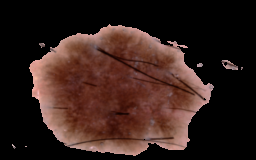

In [55]:
im = T.ToPILImage()(event['im_teste'][3][0])
im

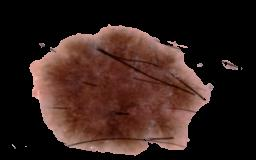

In [83]:
import base64
from io import BytesIO
from PIL import Image

def base64_to_image(base64_string):
    # Decodificar a string Base64 para bytes
    image_bytes = base64.b64decode(base64_string)

    # Criar um buffer de memória e carregar a imagem com PIL
    image = Image.open(BytesIO(image_bytes))

    return image

# Exemplo de uso com uma string Base64 (substitua pela sua)
base64_string = event["image_data"]

# Converter e exibir a imagem
img = base64_to_image(base64_string)
img  # Exibe a imagem

In [111]:
print("Diagnóstico:\n\t", event['diagnosis'],'\n', 100*"=",'\n')
print("Prognóstico:\n\t", event['prognosis'],'\n', 100*"=",'\n')
print("Relatório:\n\t", event['validation'])

Diagnóstico:
	  No image!!  

Prognóstico:
	  Without additional information about the lesion's location, size, and duration, it is difficult to provide specific details on its evolutionary pattern. However, based on common dermatological conditions such as melanocytic nevi, basal cell carcinomas, or squamous cell carcinomas, I can discuss some possible visual indicators and patterns:

1. Variations in coloration: Dermatological lesions may change color over time due to various factors like inflammation, vascularization, or melanin production. A lesion with irregular borders or a mix of colors (red, brown, black) may indicate a higher risk of worsening, as it can be indicative of malignant transformation or increased cellular activity.
2. Borders: Well-defined and smooth borders are generally considered more benign than irregular, scalloped, or poorly defined borders. The presence of an uneven border may suggest a higher risk of worsening, as it could indicate aggressive cellular growt

In [ ]:
for k, v in result_dict.items():
  print(k, ":\n\t")
  print("Diagnóstico:\n\t", v['diagnosis'],'\n', 100*"=",'\n')
  print("Prognóstico:\n\t", v['prognosis'],'\n', 100*"=",'\n')
  print("Relatório:\n\t", v['validation'])

In [ ]:
event['im_teste'][1].squeeze(0).shape

torch.Size([1, 192, 256])

In [40]:
def convert_to_base64(pil_image):
  """
  Convert PIL images to Base64 encoded strings

  :param pil_image: PIL image
  :return: Base64 string
  """
  pil_image = pil_image.convert("RGB")
  buffered = BytesIO()
  pil_image.save(buffered, format="JPEG")  # You can change the format if needed
  img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
  return img_str

In [42]:
import base64
from langchain_core.messages import HumanMessage


# # Caminho da imagem
# image_path = "/content/Image/ISIC_0016736.jpg"

# # Converter a imagem para Base64
# with open(image_path, "rb") as image_file:
#     encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
# encoded_string="iVBORw0KGgoAAAANSUhEUgAAAG0AAABmCAYAAADBPx+VAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAA3VSURBVHgB7Z27r0zdG8fX743i1bi1ikMoFMQloXRpKFFIqI7LH4BEQ+NWIkjQuSWCRIEoULk0gsK1kCBI0IhrQVT7tz/7zZo888yz1r7MnDl7z5xvsjkzs2fP3uu71nNfa7lkAsm7d++Sffv2JbNmzUqcc8m0adOSzZs3Z+/XES4ZckAWJEGWPiCxjsQNLWmQsWjRIpMseaxcuTKpG/7HP27I8P79e7dq1ars/yL4/v27S0ejqwv+cUOGEGGpKHR37tzJCEpHV9tnT58+dXXCJDdECBE2Ojrqjh071hpNECjx4cMHVycM1Uhbv359B2F79+51586daxN/+pyRkRFXKyRDAqxEp4yMlDDzXG1NPnnyJKkThoK0VFd1ELZu3TrzXKxKfW7dMBQ6bcuWLW2v0VlHjx41z717927ba22U9APcw7Nnz1oGEPeL3m3p2mTAYYnFmMOMXybPPXv2bNIPpFZr1NHn4HMw0KRBjg9NuRw95s8PEcz/6DZELQd/09C9QGq5RsmSRybqkwHGjh07OsJSsYYm3ijPpyHzoiacg35MLdDSIS/O1yM778jOTwYUkKNHWUzUWaOsylE00MyI0fcnOwIdjvtNdW/HZwNLGg+sR1kMepSNJXmIwxBZiG8tDTpEZzKg0GItNsosY8USkxDhD0Rinuiko2gfL/RbiD2LZAjU9zKQJj8RDR0vJBR1/Phx9+PHj9Z7REF4nTZkxzX4LCXHrV271qXkBAPGfP/atWvu/PnzHe4C97F48eIsRLZ9+3a3f/9+87dwP1JxaF7/3r17ba+5l4EcaVo0lj3SBq5kGTJSQmLWMjgYNei2GPT1MuMqGTDEFHzeQSP2wi/jGnkmPJ/nhccs44jvDAxpVcxnq0F6eT8h4ni/iIWpR5lPyA6ETkNXoSukvpJAD3AsXLiwpZs49+fPn5ke4j10TqYvegSfn0OnafC+Tv9ooA/JPkgQysqQNBzagXY55nO/oa1F7qvIPWkRL12WRpMWUvpVDYmxAPehxWSe8ZEXL20sadYIozfmNch4QJPAfeJgW3rNsnzphBKNJM2KKODo1rVOMRYik5ETy3ix4qWNI81qAAirizgMIc+yhTytx0JWZuNI03qsrgWlGtwjoS9XwgUhWGyhUaRZZQNNIEwCiXD16tXcAHUs79co0vSD8rrJCIW98pzvxpAWyyo3HYwqS0+H0BjStClcZJT5coMm6D2LOF8TolGJtK9fvyZpyiC5ePFi9nc/oJU4eiEP0jVoAnHa9wyJycITMP78+eMeP37sXrx44d6+fdt6f82aNdkx1pg9e3Zb5W+RSRE+n+VjksQWifvVaTKFhn5O8my63K8Qabdv33b379/PiAP//vuvW7BggZszZ072/+TJk91YgkafPn166zXB1rQHFvouAWHq9z3SEevSUerqCn2/dDCeta2jxYbr69evk4MHDyY7d+7MjhMnTiTPnz9Pfv/+nfQT2ggpO2dMF8cghuoM7Ygj5iWCqRlGFml0QC/ftGmTmzt3rmsaKDsgBSPh0/8yPeLLBihLkOKJc0jp8H8vUzcxIA1k6QJ/c78tWEyj5P3o4u9+jywNPdJi5rAH9x0KHcl4Hg570eQp3+vHXGyrmEeigzQsQsjavXt38ujRo44LQuDDhw+TW7duRS1HGgMxhNXHgflaNTOsHyKvHK5Ijo2jbFjJBQK9YwFd6RVMzfgRBmEfP37suBBm/p49e1qjEP2mwTViNRo0VJWH1deMXcNK08uUjVUu7s/zRaL+oLNxz1bpANco4npUgX4G2eFbpDFyQoQxojBCpEGSytmOH8qrH5Q9vuzD6ofQylkCUmh8DBAr+q8JCyVNtWQIidKQE9wNtLSQnS4jDSsxNHogzFuQBw4cyM61UKVsjfr3ooBkPSqqQHesUPWVtzi9/vQi1T+rJj7WiTz4Pt/l3LxUkr5P2VYZaZ4URpsE+st/dujQoaBBYokbrz/8TJNQYLSonrPS9kUaSkPeZyj1AWSj+d+VBoy1pIWVNed8P0Ll/ee5HdGRhrHhR5GGN0r4LGZBaj8oFDJitBTJzIZgFcmU0Y8ytWMZMzJOaXUSrUs5RxKnrxmbb5YXO9VGUhtpXldhEUogFr3IzIsvlpmdosVcGVGXFWp2oU9kLFL3dEkSz6NHEY1sjSRdIuDFWEhd8KxFqsRi1uM/nz9/zpxnwlESONdg6dKlbsaMGS4EHFHtjFIDHwKOo46l4TxSuxgDzi+rE2jg+BaFruOX4HXa0Nnf1lwAPufZeF8/r6zD97WK2qFnGjBxTw5qNGPxT+5T/r7/7RawFC3j4vTp09koCxkeHjqbHJqArmH5UrFKKksnxrK7FuRIs8STfBZv+luugXZ2pR/pP9Ois4z+TiMzUUkUjD0iEi1fzX8GmXyuxUBRcaUfykV0YZnlJGKQpOiGB76x5GeWkWWJc3mOrK6S7xdND+W5N6XyaRgtWJFe13GkaZnKOsYqGdOVVVbGupsyA/l7emTLHi7vwTdirNEt0qxnzAvBFcnQF16xh/TMpUuXHDowhlA9vQVraQhkudRdzOnK+04ZSP3DUhVSP61YsaLtd/ks7ZgtPcXqPqEafHkdqa84X6aCeL7YWlv6edGFHb+ZFICPlljHhg0bKuk0CSvVznWsotRu433alNdFrqG45ejoaPCaUkWERpLXjzFL2Rpllp7PJU2a/v7Ab8N05/9t27Z16KUqoFGsxnI9EosS2niSYg9SpU6B4JgTrvVW1flt1sT+0ADIJU2maXzcUTraGCRaL1Wp9rUMk16PMom8QhruxzvZIegJjFU7LLCePfS8uaQdPny4jTTL0dbee5mYokQsXTIWNY46kuMbnt8Kmec+LGWtOVIl9cT1rCB0V8WqkjAsRwta93TbwNYoGKsUSChN44lgBNCoHLHzquYKrU6qZ8lolCIN0Rh6cP0Q3U6I6IXILYOQI513hJaSKAorFpuHXJNfVlpRtmYBk1Su1obZr5dnKAO+L10Hrj3WZW+E3qh6IszE37F6EB+68mGpvKm4eb9bFrlzrok7fvr0Kfv727dvWRmdVTJHw0qiiCUSZ6wCK+7XL/AcsgNyL74DQQ730sv78Su7+t/A36MdY0sW5o40ahslXr58aZ5HtZB8GH64m9EmMZ7FpYw4T6QnrZfgenrhFxaSiSGXtPnz57e9TkNZLvTjeqhr734CNtrK41L40sUQckmj1lGKQ0rC37x544r8eNXRpnVE3ZZY7zXo8NomiO0ZUCj2uHz58rbXoZ6gc0uA+F6ZeKS/jhRDUq8MKrTho9fEkihMmhxtBI1DxKFY9XLpVcSkfoi8JGnToZO5sU5aiDQIW716ddt7ZLYtMQlhECdBGXZZMWldY5BHm5xgAroWj4C0hbYkSc/jBmggIrXJWlZM6pSETsEPGqZOndr2uuuR5rF169a2HoHPdurUKZM4CO1WTPqaDaAd+GFGKdIQkxAn9RuEWcTRyN2KSUgiSgF5aWzPTeA/lN5rZubMmR2bE4SIC4nJoltgAV/dVefZm72AtctUCJU2CMJ327hxY9t7EHbkyJFseq+EJSY16RPo3Dkq1kkr7+q0bNmyDuLQcZBEPYmHVdOBiJyIlrRDq41YPWfXOxUysi5fvtyaj+2BpcnsUV/oSoEMOk2CQGlr4ckhBwaetBhjCwH0ZHtJROPJkyc7UjcYLDjmrH7ADTEBXFfOYmB0k9oYBOjJ8b4aOYSe7QkKcYhFlq3QYLQhSidNmtS2RATwy8YOM3EQJsUjKiaWZ+vZToUQgzhkHXudb/PW5YMHD9yZM2faPsMwoc7RciYJXbGuBqJ1UIGKKLv915jsvgtJxCZDubdXr165mzdvtr1Hz5LONA8jrUwKPqsmVesKa49S3Q4WxmRPUEYdTjgiUcfUwLx589ySJUva3oMkP6IYddq6HMS4o55xBJBUeRjzfa4Zdeg56QZ43LhxoyPo7Lf1kNt7oO8wWAbNwaYjIv5lhyS7kRf96dvm5Jah8vfvX3flyhX35cuX6HfzFHOToS1H4BenCaHvO8pr8iDuwoUL7tevX+b5ZdbBair0xkFIlFDlW4ZknEClsp/TzXyAKVOmmHWFVSbDNw1l1+4f90U6IY/q4V27dpnE9bJ+v87QEydjqx/UamVVPRG+mwkNTYN+9tjkwzEx+atCm/X9WvWtDtAb68Wy9LXa1UmvCDDIpPkyOQ5ZwSzJ4jMrvFcr0rSjOUh+GcT4LSg5ugkW1Io0/SCDQBojh0hPlaJdah+tkVYrnTZowP8iq1F1TgMBBauufyB33x1v+NWFYmT5KmppgHC+NkAgbmRkpD3yn9QIseXymoTQFGQmIOKTxiZIWpvAatenVqRVXf2nTrAWMsPnKrMZHz6bJq5jvce6QK8J1cQNgKxlJapMPdZSR64/UivS9NztpkVEdKcrs5alhhWP9NeqlfWopzhZScI6QxseegZRGeg5a8C3Re1Mfl1ScP36ddcUaMuv24iOJtz7sbUjTS4qBvKmstYJoUauiuD3k5qhyr7QdUHMeCgLa1Ear9NquemdXgmum4fvJ6w1lqsuDhNrg1qSpleJK7K3TF0Q2jSd94uSZ60kK1e3qyVpQK6PVWXp2/FC3mp6jBhKKOiY2h3gtUV64TWM6wDETRPLDfSakXmH3w8g9Jlug8ZtTt4kVF0kLUYYmCCtD/DrQ5YhMGbA9L3ucdjh0y8kOHW5gU/VEEmJTcL4Pz/f7mgoAbYkAAAAAElFTkSuQmCC"
# encoded_string=image_path

# msg = [{"role": "user",
#         # "content": "Descreva a imagem",
#         "content": "What is in this picture?",
#         # "content": "Descreva a imagem com base no checklist de 7 pontos para detecção de cancer de pele .",
#         "image": [encoded_string]
#         }]
# encoded_string = event['image_data']
encoded_string = convert_to_base64(T.ToPILImage()(event['im_teste'][3][0]))
content_str = """
        Describe in detail the specific visual characteristics of the analyzed lesion. Include information on texture,
        color, borders, shape, and observed internal patterns. Compare these characteristics with known patterns of skin
        lesions documented in medical literature. Provide an objective assessment without offering diagnoses, only
        detailing similarities and differences with recognized dermatological conditions. If no image is available,
        return only the following text: "No image!!!"
"""
content = [
    {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{encoded_string}'},
    {'type': 'text', 'text': content_str}#'Describe the image'}
]
msg = [HumanMessage(content=content)]
response = llm.invoke(msg)
print(response.content)

 The image provided shows a circular, irregularly shaped lesion with a rough, uneven texture that suggests scales or crusts. The central area of the lesion appears to be more crusted and darker in color, which can be indicative of hyperkeratosis or increased cellular growth, whereas the outer edges seem to be smoother with less scale-like appearance.

The coloration varies throughout the lesion, with the central portion showing a darker hue that could imply an increase in melanin pigment, potentially suggesting a benign or atypical melanocytic proliferation. The borders are uneven and irregular, which is characteristic of certain types of skin lesions such as keratinocytes (KC) or possibly actinic keratosis (AK).

The observed internal patterns within the lesion include what appears to be a central area with more scale-like formations and a darker coloration, surrounded by a less crusted, smoother outer edge. This pattern is reminiscent of some forms of AK or possibly a non-neoplastic 